#### Jupyter notebook with code for analysis of tracking data of experiments manipulating nutritional state in *Ooceraea biroi*

In [1]:
#imports
import glob, os
import numpy as np
import pandas as pd
import seaborn as sns
import h5py
import scipy.io as spio
import scipy
import random
import cv2

import matplotlib.pyplot as plt
from matplotlib.pyplot import plot
import matplotlib.patches as mpatches

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

from raid_functions import *

%matplotlib inline

/Users/vchandra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.


In [2]:
#set working directory for data
fullpath = './tracking_data/'
os.chdir(fullpath)

In [3]:
#import datafile with links to tracking output from antrax
coldata = pd.read_csv('STV7_coldata.csv')
coldata.head()

,Colony,HDD,Cam,Event
0,SF1,STV7_4,CAM4,1
1,SF1,STV7_4,CAM4,2
2,SF1,STV7_4,CAM4,3
3,SF1,STV7_4,CAM4,4
4,SF1,STV7_4,CAM4,5


In [4]:
#calculate nest position, add to coldata
nestlist = []
scalelist = []
for ind, row in coldata.iterrows():
    nest, scale = getnestcoordinates(row['Colony'], row['Event'], coldata)
    nestlist.append(nest)
    scalelist.append(float(scale))
    
print(len(nestlist))
print(len(scalelist))
print(len(coldata))

coldata['Nest'] = nestlist
coldata['Scale'] = scalelist

96
96
96


In [5]:
coldata.head()

,Colony,HDD,Cam,Event,Nest,Scale
0,SF1,STV7_4,CAM4,1,"[1831.0, 1465.0]",0.000054
1,SF1,STV7_4,CAM4,2,"[1831.0, 1465.0]",0.000054
2,SF1,STV7_4,CAM4,3,"[1831.0, 1465.0]",0.000054
3,SF1,STV7_4,CAM4,4,"[1831.0, 1465.0]",0.000054
4,SF1,STV7_4,CAM4,5,"[1831.0, 1465.0]",0.000054


#### measure a) total distance travelled, b) number of ants outside the nest at any time, c) average distance from nest for mixed colonies

In [6]:
filelist = ['STV7_3/STV7_2018_06_17_20_56_23_cam_0/', 
                 'STV7_3/STV7_2018_06_17_20_56_23_cam_1/', 
                'STV7_3/STV7_2018_06_17_20_56_23_cam_2/', 
                'STV7_3/STV7_2018_06_17_20_56_23_cam_3/', 
                'STV7_4/STV7_2018_06_17_20_56_23_cam_4/',
                'STV7_4/STV7_2018_06_17_20_56_23_cam_5/',
                'STV7_4/STV7_2018_06_17_20_56_23_cam_6/',
                'STV7_4/STV7_2018_06_17_20_56_23_cam_7/']

firstfilelist = ['STV7_3/STV7_2018_06_17_20_56_23_cam_0/1_3.mat', 
                 'STV7_3/STV7_2018_06_17_20_56_23_cam_1/1_3.mat', 
                'STV7_3/STV7_2018_06_17_20_56_23_cam_2/1_3.mat', 
                'STV7_3/STV7_2018_06_17_20_56_23_cam_3/1_3.mat', 
                'STV7_4/STV7_2018_06_17_20_56_23_cam_4/1_3.mat',
                'STV7_4/STV7_2018_06_17_20_56_23_cam_5/1_3.mat',
                'STV7_4/STV7_2018_06_17_20_56_23_cam_6/1_3.mat',
                'STV7_4/STV7_2018_06_17_20_56_23_cam_7/1_3.mat']

secondfilelist = ['STV7_3/STV7_2018_06_17_20_56_23_cam_0/4_13.mat', 
                 'STV7_3/STV7_2018_06_17_20_56_23_cam_1/4_13.mat', 
                'STV7_3/STV7_2018_06_17_20_56_23_cam_2/4_13.mat', 
                'STV7_3/STV7_2018_06_17_20_56_23_cam_3/4_13.mat', 
                'STV7_4/STV7_2018_06_17_20_56_23_cam_4/4_13.mat',
                'STV7_4/STV7_2018_06_17_20_56_23_cam_5/4_13.mat',
                'STV7_4/STV7_2018_06_17_20_56_23_cam_6/4_13.mat',
                'STV7_4/STV7_2018_06_17_20_56_23_cam_7/4_13.mat']

collist = ['SF8', 'SF6', 'SF2', 'SF7', 'SF1', 'SF4', 'SF3', 'SF5']

SF8
SF6
SF2
SF7
SF1
SF4
SF3
SF5


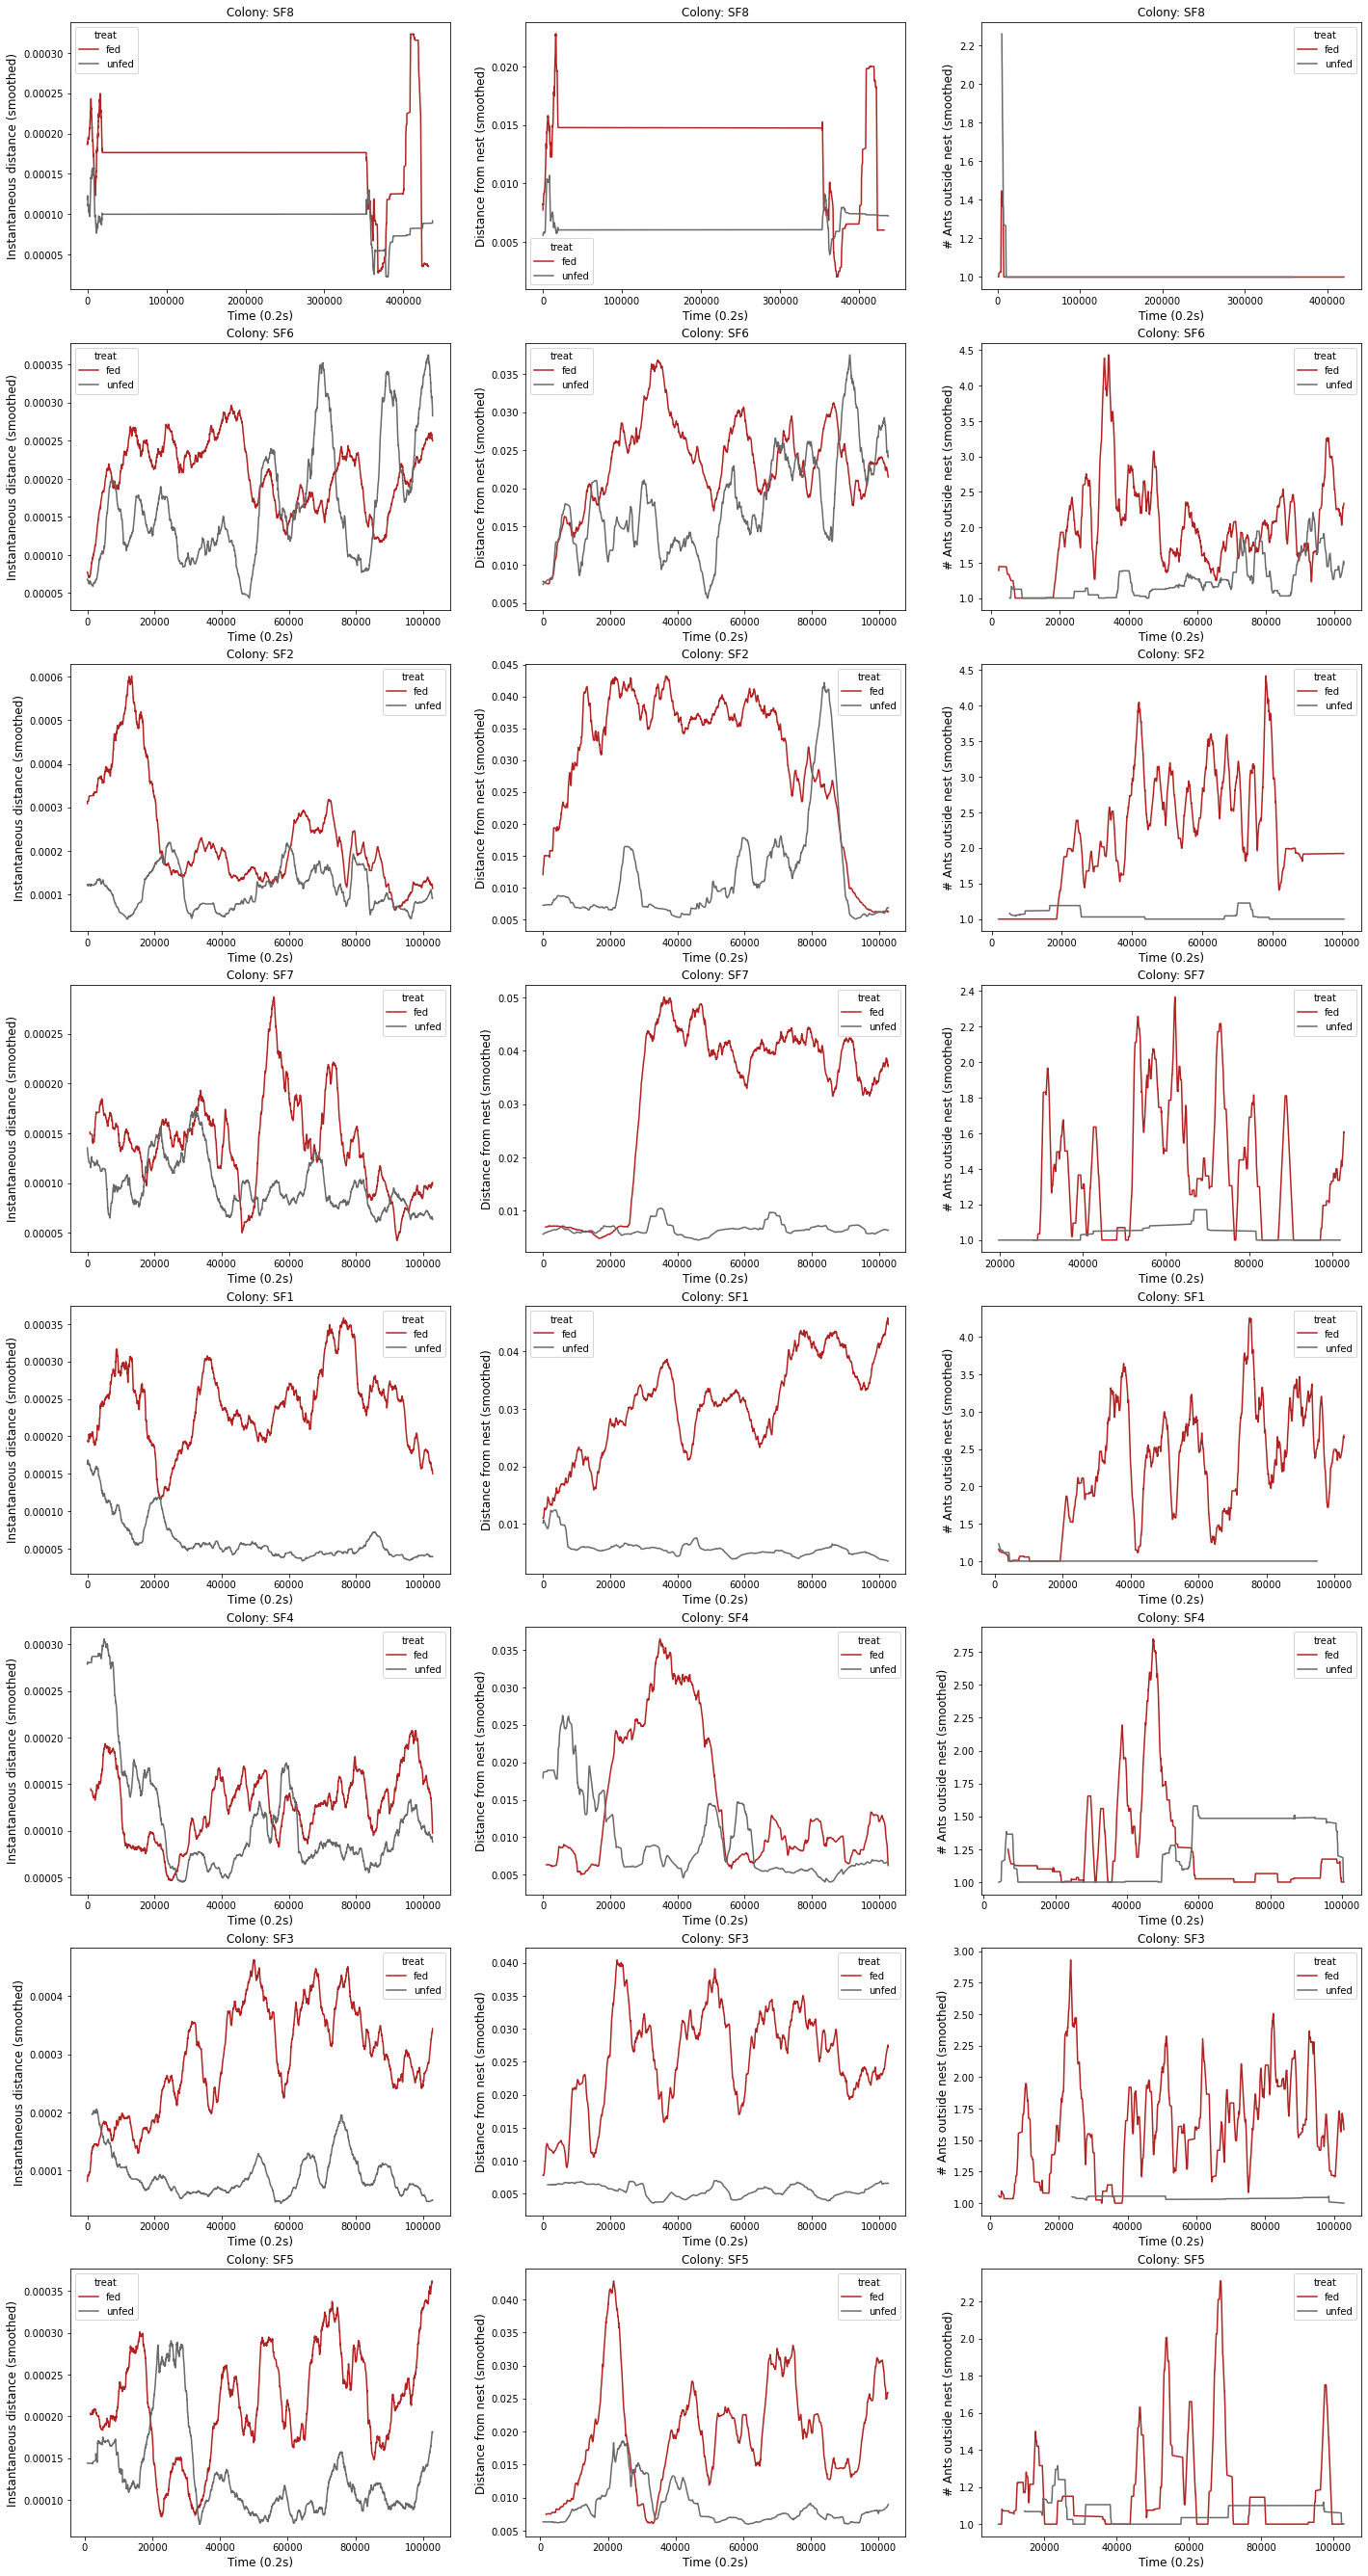

In [7]:
alldata = pd.DataFrame()

plt.figure(figsize = (24, 6 * 8))

count = 0 
index = 1
for movie in filelist:
    
    #load data and pre-process
    data = pd.DataFrame(columns = ['colony', 'meandist', 'dfn', 'nants', 'treat'])
    data_f = pd.DataFrame(columns = ['colony', 'meandist', 'dfn', 'nants', 'treat'])
    data_s = pd.DataFrame(columns = ['colony', 'meandist', 'dfn', 'nants', 'treat'])
    
    f0 = scipy.io.loadmat(movie + '1_3.mat')
    f1 = scipy.io.loadmat(movie + '4_13.mat')
    feddata = pd.DataFrame(f0['Y']).append(pd.DataFrame(f1['Y']))
    starvdata = pd.DataFrame(f0['P']).append(pd.DataFrame(f1['P']))
    feddata.columns = ['frame', 'x', 'y']
    starvdata.columns = ['frame', 'x', 'y']

    dx = (feddata['x'] - feddata['x'].shift())
    dy = (feddata['y'] - feddata['y'].shift())
    dxs = (starvdata['x'] - starvdata['x'].shift())
    dys = (starvdata['y'] - starvdata['y'].shift())

    feddata['s_inst'] = np.sqrt(dx**2 + dy**2)
    starvdata['s_inst'] = np.sqrt(dxs**2 + dys**2)
    
    #distfromnest
    nest = coldata['Nest'][coldata['Colony'] == collist[count]].iloc[0]
    scale = float(coldata['Scale'][coldata['Colony'] == collist[count]].iloc[0])
    nest2 = ''.join(str(nest).split())
    nest2 = nest2[1:-1]
    nest2 = nest2.split(',')
    nest_x = float(nest2[0]) * scale
    nest_y = float(nest2[1]) * scale
    feddata['distfromnest'] = np.sqrt((feddata['x'] - nest_x)**2 + (feddata['y'] - nest_y)**2)
    starvdata['distfromnest'] = np.sqrt((starvdata['x'] - nest_x)**2 + (starvdata['y'] - nest_y)**2)
    feddata['pos'] = 'in'
    starvdata['pos'] = 'in'
    radius = 0.018
    feddata.loc[feddata['distfromnest'] > radius, 'pos'] = 'out'
    starvdata.loc[starvdata['distfromnest'] > radius, 'pos'] = 'out'
    
    #remove data from inside nest
    fout = feddata[feddata['pos'] == 'out']
    sout = starvdata[starvdata['pos'] == 'out']
    
    #SERIOUS ANALYSIS BEGINS HERE
    #number of ants outside the nest per frame
    fg = feddata[['frame', 's_inst', 'distfromnest']].groupby(['frame'])
    sg = starvdata[['frame', 's_inst', 'distfromnest']].groupby(['frame'])
    fgout = fout.groupby(['frame'])
    sgout = sout.groupby(['frame'])
    fdata = fg.mean()
    sdata = sg.mean()
    fdata.reset_index(inplace = True)
    sdata.reset_index(inplace = True)
    fdata['treat'] = 'fed'
    sdata['treat'] = 'unfed'
    
    grf = pd.DataFrame(fgout.size())
    grs = pd.DataFrame(sgout.size())
    grf.reset_index(inplace = True)
    grs.reset_index(inplace = True)
    grf = grf.rename(columns = {0: 'nants'})
    grf['treat'] = 'fed'
    grs['treat'] = 'unfed'
    grs = grs.rename(columns = {0: 'nants'})
    
    #metrics agg
    data_f.at[0, 'colony'] = collist[count]
    data_s.at[0, 'colony'] = collist[count]
    data_f.at[0, 'meandist'] = fdata['s_inst'].mean()
    data_s.at[0, 'meandist'] = sdata['s_inst'].mean()
    data_f.at[0, 'dfn'] = fdata['distfromnest'].mean()
    data_s.at[0, 'dfn'] = sdata['distfromnest'].mean()
    data_f.at[0, 'nants'] = np.mean(fgout.size())
    data_s.at[0, 'nants'] = np.mean(sgout.size())
    data_f.at[0, 'treat'] = 'fed'
    data_s.at[0, 'treat'] = 'unfed'
    
    data = data_f.append(data_s, ignore_index = True)
    
    #subsample and smooth for plots
    fdata = fdata.iloc[::10,:]
    sdata = sdata.iloc[::10,:]
    fdata['s_inst'] = pd.DataFrame(fdata['s_inst'].rolling(500, min_periods = 20, center = True).mean())
    sdata['s_inst'] = pd.DataFrame(sdata['s_inst'].rolling(500, min_periods = 20, center = True).mean())
    fdata['distfromnest'] = pd.DataFrame(fdata['distfromnest'].rolling(500, min_periods = 20, center = True).mean())
    sdata['distfromnest'] = pd.DataFrame(sdata['distfromnest'].rolling(500, min_periods = 20, center = True).mean())
    
    print(collist[count])
    tdata = fdata.append(sdata, ignore_index = True)
    
    #plots
    plt.subplot(8, 3, index)
    sns.lineplot(x = 'frame', y = 's_inst', hue = 'treat', data = tdata, palette = ['firebrick', 'dimgrey'])
    plt.ylabel('Instantaneous distance (smoothed)', fontsize = 12)
    plt.xlabel('Time (0.2s)', fontsize = 12)
    plt.title('Colony: ' + str(collist[count]))
    
    plt.subplot(8, 3, index+1)
    sns.lineplot(x = 'frame', y = 'distfromnest', hue = 'treat', data = tdata, palette = ['firebrick', 'dimgrey'])
    plt.ylabel('Distance from nest (smoothed)', fontsize = 12)
    plt.xlabel('Time (0.2s)', fontsize = 12)
    plt.title('Colony: ' + str(collist[count]))

    #collate all
    alldata = alldata.append(data, ignore_index = True)
    
    if grf.empty or grs.empty:
        print('no ants detected outside nest in colony ' + str(collist[count])) 
        
    else:
        grf = grf.iloc[::10,:]
        grs = grs.iloc[::10,:]
        grf['nants'] = pd.DataFrame(grf['nants'].rolling(200, min_periods = 20, center = True).mean())
        grs['nants'] = pd.DataFrame(grs['nants'].rolling(200, min_periods = 20, center = True).mean())
        gr = grf.append(grs, ignore_index = True)
        
    
        plt.subplot(8, 3, index+2)
        sns.lineplot(x = 'frame', y = 'nants', hue = 'treat', data = gr, palette = ['firebrick', 'dimgrey'])
        plt.ylabel('# Ants outside nest (smoothed)', fontsize = 12)
        plt.xlabel('Time (0.2s)', fontsize = 12)
        plt.title('Colony: ' + str(collist[count]))
    
    
    count += 1
    index += 3

In [8]:
alldata['meandist'] = alldata.meandist.astype(float)
alldata['dfn'] = alldata.dfn.astype(float)
alldata['nants'] = alldata.nants.astype(float)
alldata['dfn_mm'] = alldata['dfn'] * 1000
alldata['meandist_mm'] = alldata['meandist'] * 1000
alldata

,colony,meandist,dfn,nants,treat,dfn_mm,meandist_mm
0,SF8,0.000130,0.010510,1.065988,fed,10.509775,0.130051
1,SF8,0.000083,0.007123,1.457785,unfed,7.123075,0.083396
2,SF6,0.000204,0.023403,2.012573,fed,23.402745,0.204394
3,SF6,0.000163,0.017858,1.303488,unfed,17.858475,0.163449
4,SF2,0.000222,0.031012,2.291806,fed,31.012169,0.222295
5,SF2,0.000113,0.012039,1.043398,unfed,12.039168,0.112657
6,SF7,0.000139,0.033225,1.396693,fed,33.224844,0.139233
7,SF7,0.000097,0.006503,1.050656,unfed,6.503235,0.097457
8,SF1,0.000239,0.031034,2.276386,fed,31.033656,0.239200
9,SF1,0.000061,0.005693,1.038835,unfed,5.692686,0.060844


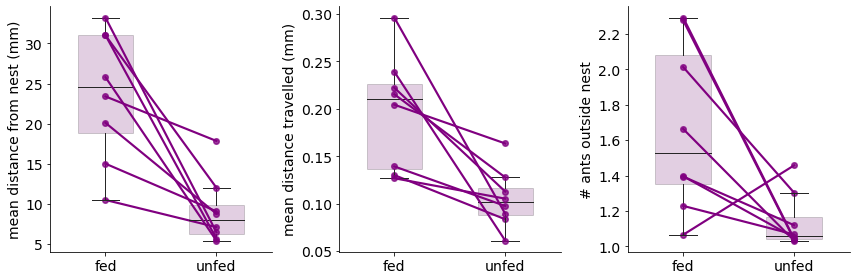

In [32]:
fig, [ax0, ax1, ax2] = plt.subplots(1, 3, figsize = (12, 4))

sns.pointplot(x = 'treat', y = 'dfn_mm', data = alldata, hue = 'colony',
              dodge = False, palette = ['purple'], scale = 0.8, ax = ax0)
handles, _ = ax0.get_legend_handles_labels()
sns.boxplot(x = 'treat', y = 'dfn_mm', data = alldata, width = 0.5, fliersize = 0, 
           linewidth = 1, boxprops = {'alpha' : 0.2}, color = 'purple', ax = ax0)
ax0.set_ylabel('mean distance from nest (mm)', fontsize = 14)

sns.pointplot(x = 'treat', y = 'meandist_mm', data = alldata, hue = 'colony', 
              dodge = False, palette = ['purple'], scale = 0.8, ax = ax1)
sns.boxplot(x = 'treat', y = 'meandist_mm', data = alldata, width = 0.5, fliersize = 0, 
           linewidth = 1, boxprops = {'alpha' : 0.2}, color = 'purple', ax = ax1)
ax1.set_ylabel('mean distance travelled (mm)', fontsize = 14)

sns.pointplot(x = 'treat', y = 'nants', data = alldata, hue = 'colony', 
              dodge = False, palette = ['purple'], scale = 0.8, ax = ax2)
sns.boxplot(x = 'treat', y = 'nants', data = alldata, width = 0.5, fliersize = 0, 
           linewidth = 1, boxprops = {'alpha' : 0.2}, color = 'purple', ax = ax2)
ax2.set_ylabel('# ants outside nest', fontsize = 14)

for i in [ax0, ax1, ax2]:
    plt.setp(i.collections, alpha = 0.75)
    i.legend(handles, '', frameon = False)
    i.set_xlabel('')
    i.spines['right'].set_visible(False)
    i.spines['top'].set_visible(False)
    i.tick_params(axis = 'both', which = 'major', labelsize = 14)
    
plt.tight_layout()

#### plot example spatial histograms for one fed and one unfed colony

In [33]:
f0 = scipy.io.loadmat('STV7_1/STV7_2018_06_17_20_54_44_cam_0/1_3.mat')
f1 = scipy.io.loadmat('STV7_1/STV7_2018_06_17_20_54_44_cam_0/4_14.mat')
data = pd.DataFrame(f0['U']).append(pd.DataFrame(f1['U']))
data.columns = ['frame', 'x', 'y']
temp = data.dropna(subset = ['x', 'y'])
heatmap, xedges, yedges = np.histogram2d(temp['x'], temp['y'], bins = 100)
                                         
s0 = scipy.io.loadmat('STV7_1/STV7_2018_06_17_20_54_44_cam_3/1_3.mat')
s1 = scipy.io.loadmat('STV7_1/STV7_2018_06_17_20_54_44_cam_3/4_14.mat')
sdata = pd.DataFrame(s0['U']).append(pd.DataFrame(s1['U']))
sdata.columns = ['frame', 'x', 'y']
stemp = sdata.dropna(subset = ['x', 'y'])
sheatmap, xedges, yedges = np.histogram2d(stemp['x'], stemp['y'], bins = 100)

[]

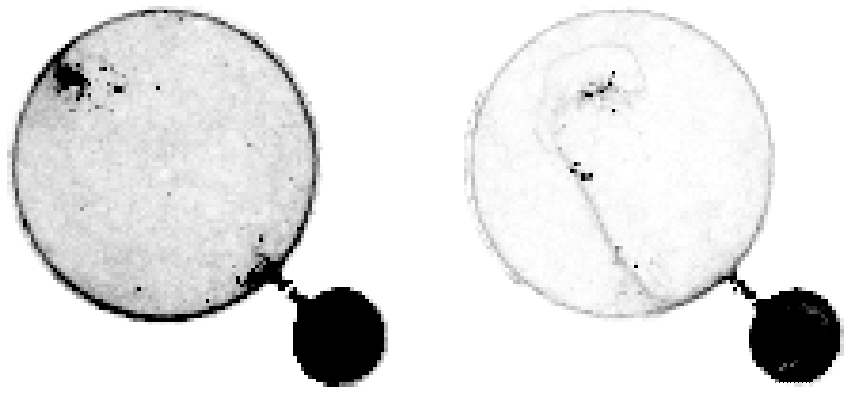

In [34]:
fig, [ax0, ax1] = plt.subplots(1, 2, figsize = (15,7.5))
cmap = 'binary'

sns.heatmap(heatmap, vmin = 0, vmax = 300, square = True, cmap = cmap, ax = ax0, cbar = None)
sns.heatmap(sheatmap, vmin = 0, vmax = 300, square = True, cmap = cmap, ax = ax1, cbar = None)

# split axes of heatmap to put colorbar
#ax_divider = make_axes_locatable(ax0)
# define size and padding of axes for colorbar
#cax = ax_divider.append_axes('right', size = '3%', pad = '5%')
# make colorbar for heatmap. 
# Heatmap returns an axes obj but you need to get a mappable obj (get_children)
#colorbar(ax0.get_children()[0], cax = cax)

#cax.tick_params(labelsize=14) 
ax0.invert_xaxis()
ax0.set_xticks([])
ax0.set_yticks([])
ax1.set_xticks([])
ax1.set_yticks([])

#### measure a) total distance travelled, b) number of ants outside the nest at any time, c) average distance from nest for homogenous colonies

In [41]:
flist = ['STV7_1/STV7_2018_06_17_20_54_44_cam_0/', 
                 'STV7_1/STV7_2018_06_17_20_54_44_cam_1/', 
                'STV7_1/STV7_2018_06_17_20_54_44_cam_2/', 
                'STV7_1/STV7_2018_06_17_20_54_44_cam_3/', 
                'STV7_2/STV7_2018_06_17_20_54_44_cam_4/',
                'STV7_2/STV7_2018_06_17_20_54_44_cam_5/',
                'STV7_2/STV7_2018_06_17_20_54_44_cam_6/',
                'STV7_2/STV7_2018_06_17_20_54_44_cam_7/']

homcollist = ['F4', 'F3', 'F1', 'S2', 'S4', 'F2', 'S3', 'S1']

F4
F3
F1
S2
S4
F2
S3
S1


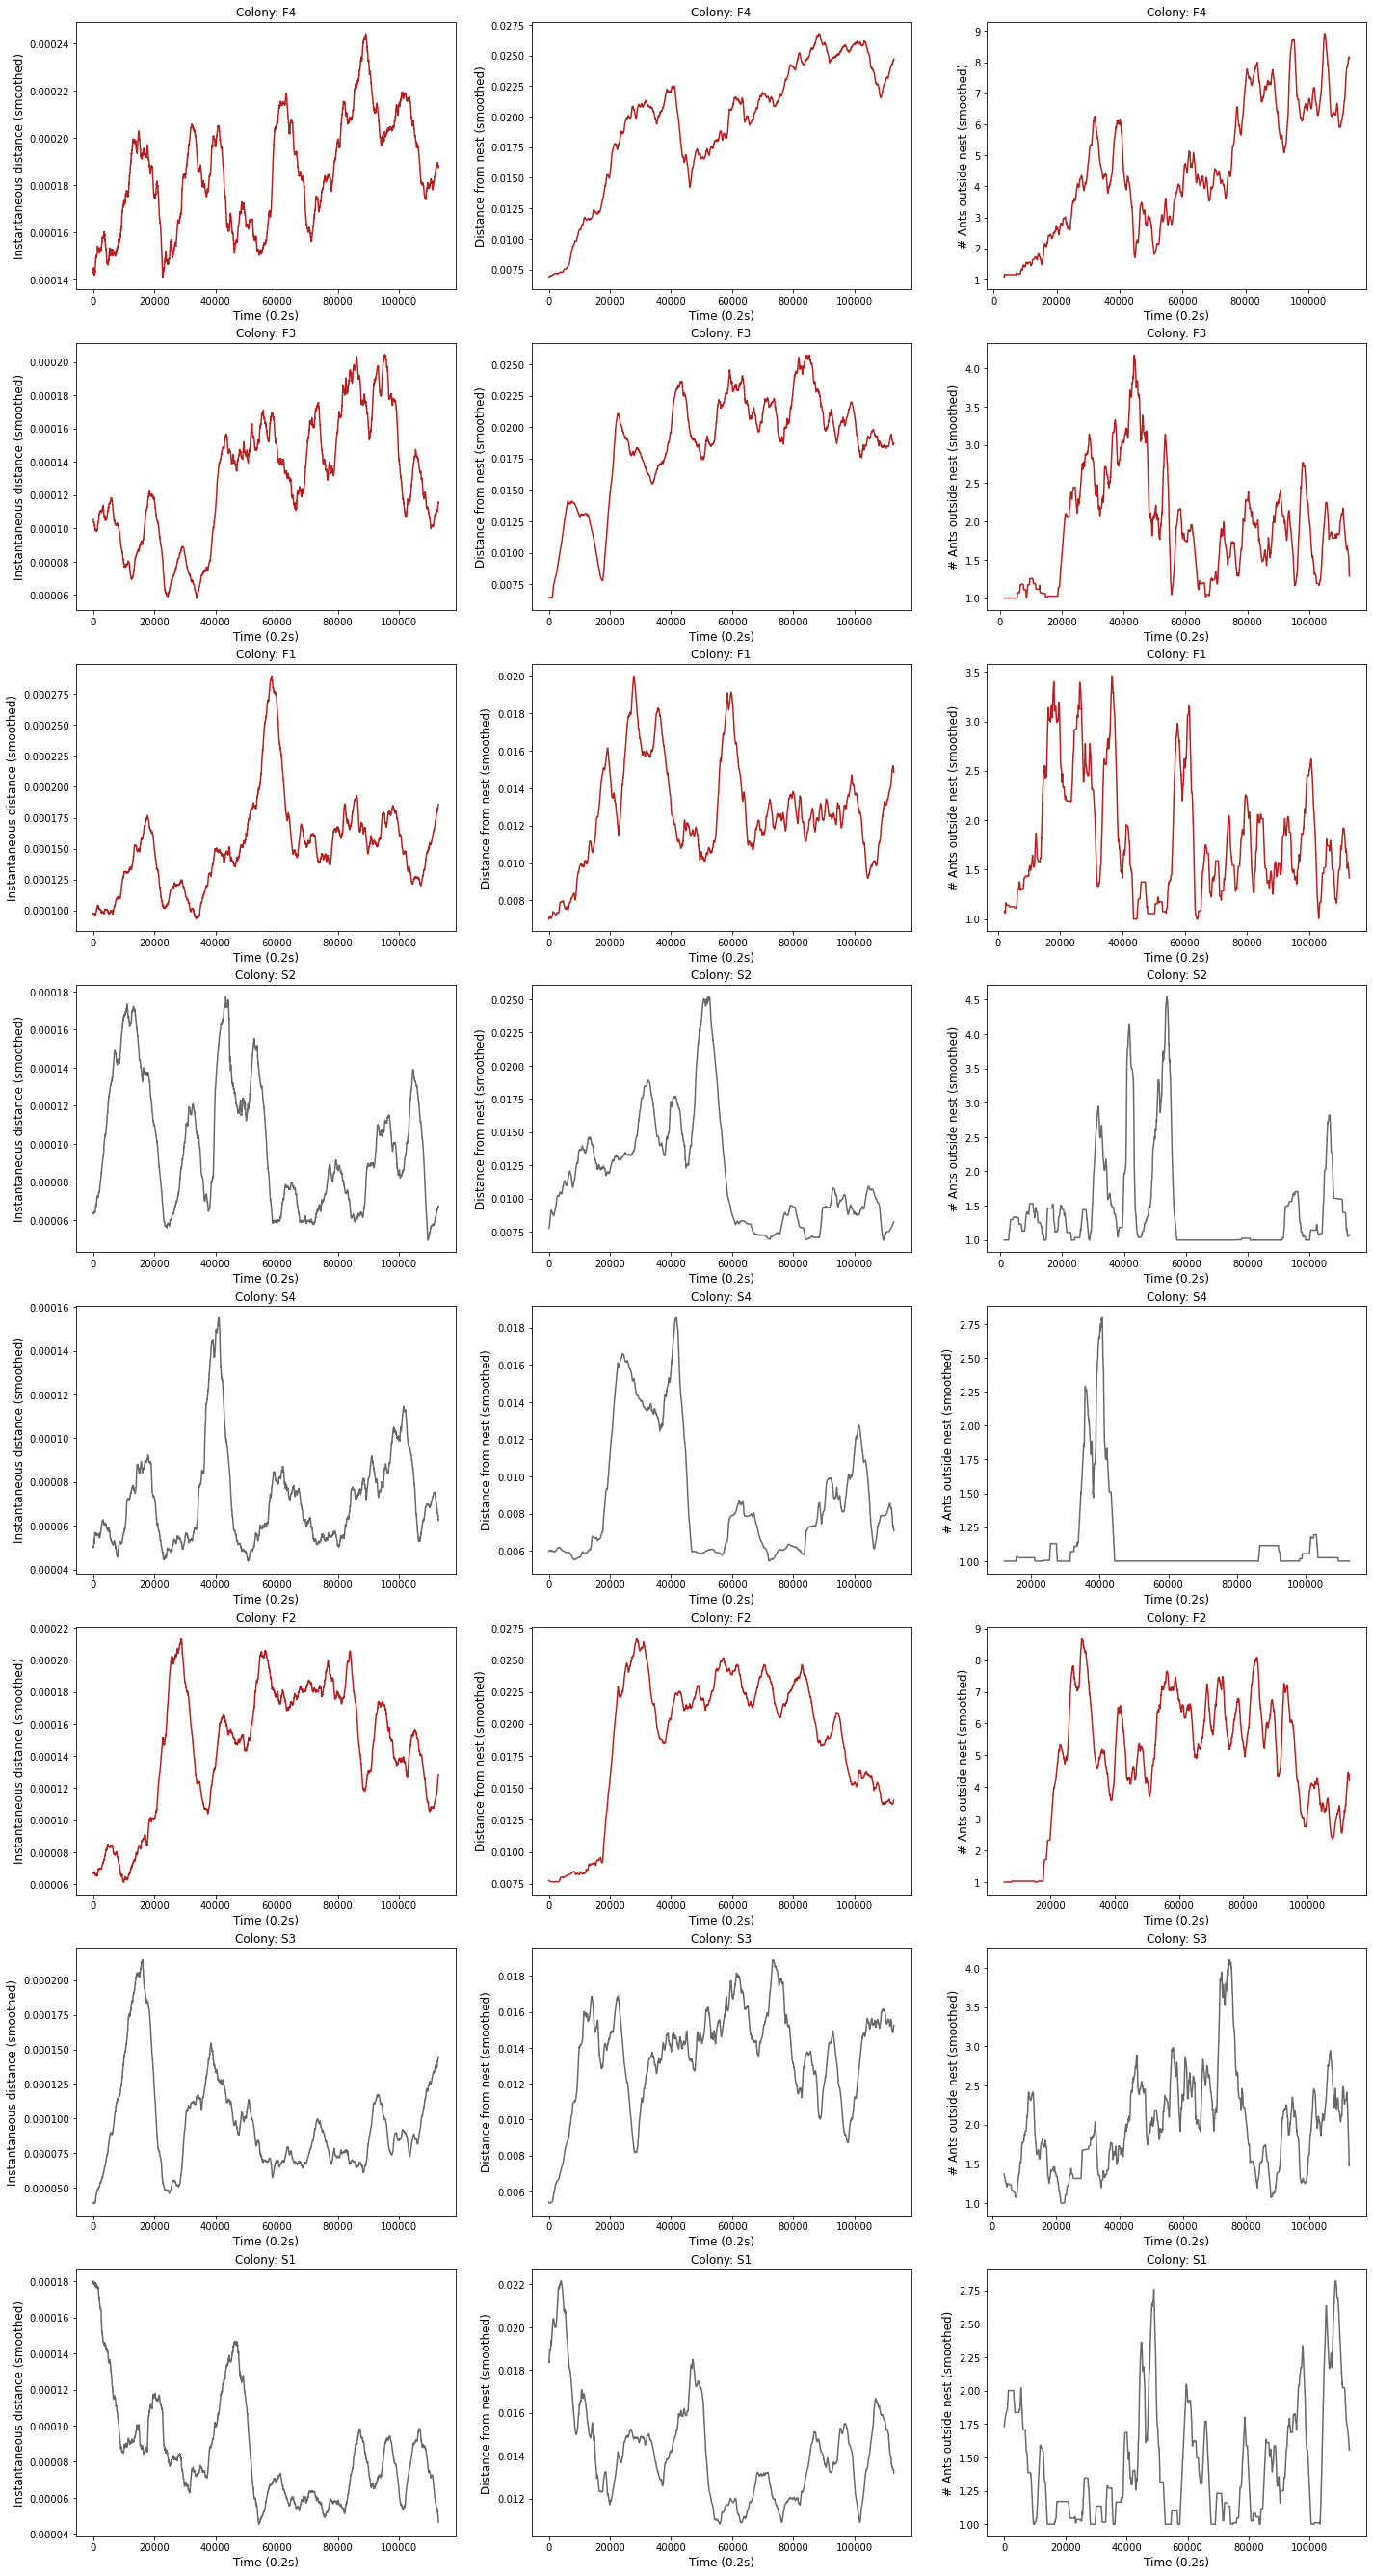

In [42]:
homdata = pd.DataFrame()

plt.figure(figsize = (24, 6 * 8))

count = 0 
index = 1


for movie in flist:
    color = ''
    
    #load data and pre-process
    data_f = pd.DataFrame(columns = ['colony', 'meandist', 'dfn', 'nants', 'treat'])
    
    f0 = scipy.io.loadmat(movie + '1_3.mat')
    f1 = scipy.io.loadmat(movie + '4_14.mat')
    feddata = pd.DataFrame(f0['U']).append(pd.DataFrame(f1['U']))
    feddata.columns = ['frame', 'x', 'y']

    dx = (feddata['x'] - feddata['x'].shift())
    dy = (feddata['y'] - feddata['y'].shift())

    feddata['s_inst'] = np.sqrt(dx**2 + dy**2)
    
    #distfromnest
    nest = coldata['Nest'][coldata['Colony'] == homcollist[count]].iloc[0]
    scale = float(coldata['Scale'][coldata['Colony'] == homcollist[count]].iloc[0])
    nest2 = ''.join(str(nest).split())
    nest2 = nest2[1:-1]
    nest2 = nest2.split(',')
    nest_x = float(nest2[0]) * scale
    nest_y = float(nest2[1]) * scale
    feddata['distfromnest'] = np.sqrt((feddata['x'] - nest_x)**2 + (feddata['y'] - nest_y)**2)
    feddata['pos'] = 'in'
    radius = 0.018
    feddata.loc[feddata['distfromnest'] > radius, 'pos'] = 'out'
    
    #remove data from inside nest, but only for nant analysis
    fout = feddata[feddata['pos'] == 'out']
    
    #SERIOUS ANALYSIS BEGINS HERE
    #number of ants outside the nest per frame
    fg = feddata[['frame', 's_inst', 'distfromnest']].groupby(['frame'])
    fgout = fout.groupby(['frame'])
    fdata = fg.mean()
    fdata.reset_index(inplace = True)
    if 'F' in homcollist[count]:
        fdata['treat'] = 'fed'
        color = 'firebrick'
    elif 'S' in homcollist[count]:
        fdata['treat'] = 'unfed'
        color = 'dimgrey'
    
    grf = pd.DataFrame(fgout.size())
    grf.reset_index(inplace = True)
    grf = grf.rename(columns = {0: 'nants'})
    if 'F' in homcollist[count]:
        grf['treat'] = 'fed'
    elif 'S' in homcollist[count]:
        grf['treat'] = 'unfed'
    
    #metrics agg
    data_f.at[0, 'colony'] = homcollist[count]
    data_f.at[0, 'meandist'] = fdata['s_inst'].mean()
    data_f.at[0, 'dfn'] = fdata['distfromnest'].mean()
    data_f.at[0, 'nants'] = np.mean(fgout.size())
    if 'F' in homcollist[count]:
        data_f.at[0, 'treat'] = 'fed'
    elif 'S' in homcollist[count]:
        data_f.at[0, 'treat'] = 'unfed'
    
    #subsample and smooth for plots
    fdata = fdata.iloc[::10,:]
    fdata['s_inst'] = pd.DataFrame(fdata['s_inst'].rolling(500, min_periods = 20, center = True).mean())
    fdata['distfromnest'] = pd.DataFrame(fdata['distfromnest'].rolling(500, min_periods = 20, center = True).mean())
    
    print(homcollist[count])
    
    #plots
    plt.subplot(8, 3, index)
    sns.lineplot(x = 'frame', y = 's_inst', data = fdata, color = color)
    plt.ylabel('Instantaneous distance (smoothed)', fontsize = 12)
    plt.xlabel('Time (0.2s)', fontsize = 12)
    plt.title('Colony: ' + str(homcollist[count]))
    
    plt.subplot(8, 3, index+1)
    sns.lineplot(x = 'frame', y = 'distfromnest', data = fdata, color = color)
    plt.ylabel('Distance from nest (smoothed)', fontsize = 12)
    plt.xlabel('Time (0.2s)', fontsize = 12)
    plt.title('Colony: ' + str(homcollist[count]))

    #collate all
    homdata = homdata.append(data_f, ignore_index = True)
    
    if grf.empty:
        print('no ants detected outside nest in colony ' + str(homcollist[count])) 
        
    else:
        grf = grf.iloc[::10,:]
        grf['nants'] = pd.DataFrame(grf['nants'].rolling(200, min_periods = 20, center = True).mean())
    
        plt.subplot(8, 3, index+2)
        sns.lineplot(x = 'frame', y = 'nants', data = grf, color = color)
        plt.ylabel('# Ants outside nest (smoothed)', fontsize = 12)
        plt.xlabel('Time (0.2s)', fontsize = 12)
        plt.title('Colony: ' + str(homcollist[count]))
    
    
    count += 1
    index += 3

In [43]:
homdata['meandist'] = homdata.meandist.astype(float)
homdata['dfn'] = homdata.dfn.astype(float)
homdata['nants'] = homdata.nants.astype(float)
homdata['meandist_mm'] = homdata['meandist'] * 1000
homdata['dfn_mm'] = homdata['dfn'] * 1000

In [44]:
homdata

,colony,meandist,dfn,nants,treat,meandist_mm,dfn_mm
0,F4,0.000186,0.019579,4.754658,fed,0.185523,19.578684
1,F3,0.000128,0.018707,1.970298,fed,0.128384,18.706921
2,F1,0.000151,0.012741,1.884855,fed,0.151237,12.741487
3,S2,0.000099,0.011796,1.640355,unfed,0.099343,11.795741
4,S4,0.000072,0.008896,1.239179,unfed,0.072166,8.896328
5,F2,0.000146,0.018847,5.258216,fed,0.146016,18.847027
6,S3,0.000097,0.013617,2.055864,unfed,0.096760,13.617062
7,S1,0.000085,0.014151,1.464799,unfed,0.084728,14.151262


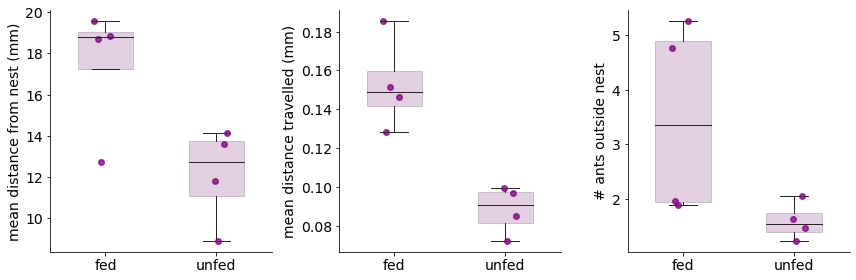

In [45]:
fig, [ax0, ax1, ax2] = plt.subplots(1, 3, figsize = (12, 4))

sns.pointplot(x = 'treat', y = 'dfn_mm', data = homdata, hue = 'colony',
              dodge = True, palette = ['purple'], scale = 0.8, ax = ax0)
handles, _ = ax0.get_legend_handles_labels()
sns.boxplot(x = 'treat', y = 'dfn_mm', data = homdata, width = 0.5, fliersize = 0, 
           linewidth = 1, boxprops = {'alpha' : 0.2}, color = 'purple', ax = ax0)
ax0.set_ylabel('mean distance from nest (mm)', fontsize = 14)

sns.pointplot(x = 'treat', y = 'meandist_mm', data = homdata, hue = 'colony', 
              dodge = True, palette = ['purple'], scale = 0.8, ax = ax1)
sns.boxplot(x = 'treat', y = 'meandist_mm', data = homdata, width = 0.5, fliersize = 0, 
           linewidth = 1, boxprops = {'alpha' : 0.2}, color = 'purple', ax = ax1)
ax1.set_ylabel('mean distance travelled (mm)', fontsize = 14)

sns.pointplot(x = 'treat', y = 'nants', data = homdata, hue = 'colony', 
              dodge = True, palette = ['purple'], scale = 0.8, ax = ax2)
sns.boxplot(x = 'treat', y = 'nants', data = homdata, width = 0.5, fliersize = 0, 
           linewidth = 1, boxprops = {'alpha' : 0.2}, color = 'purple', ax = ax2)
ax2.set_ylabel('# ants outside nest', fontsize = 14)

for i in [ax0, ax1, ax2]:
    plt.setp(i.collections, alpha = 0.75)
    i.legend(handles, '', frameon = False)
    i.set_xlabel('')
    i.spines['right'].set_visible(False)
    i.spines['top'].set_visible(False)
    i.tick_params(axis = 'both', which = 'major', labelsize = 14)
    
plt.tight_layout()